In [1]:
import os, glob, shutil, sys, copy, time, json, copy, subprocess
from IPython import display
from tqdm import tqdm
from pycromanager import Acquisition, Bridge, Dataset, multi_d_acquisition_events
from skimage import io, img_as_ubyte, img_as_float, color, transform, exposure
from skimage.filters import threshold_mean, sobel
from skimage.measure import shannon_entropy
from skimage.util import view_as_windows, crop
import imagej
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import norm
import scipy as sp
from shapely.geometry import mapping, shape
from tkinter import filedialog
import warnings

from acquisitions import *
from image_utils import *

In [2]:
# os.environ['JAVA_MEM'] = '-Xmx4096m'
os.environ['_JAVA_OPTIONS']="-Xmx8g"
warnings.filterwarnings('ignore')
Image.MAX_IMAGE_PIXELS = None        

In [3]:
config = {
    "pixel-size-bf-20x" : 0.256, # 0.508
    "pixel-size-bf-4x" : 1.305, # micron/pixel
    "pixel-size-shg" : 0.257, # 512 base at 0.257
    "camera-resolution" : (1392, 1040), # (width, height)
#    "camera-resolution" : (512, 512), # (width, height)
    "lsm-resolution-base" : (512, 512),  
    "slide-size" : (38000.0, 18000.0), # (width, height) (70000, -20000)
#    "slide-size" : (4000, 2000), # (width, height) (70000, -20000)
    "slide-start" : (0, 0), # x, y
    "Z-stage-20x" : -7150,
    "Z-stage-laser" : -6625, #-5550
    "Z-stage-4x" : -2300, # -2300
    "F-stage-20x" : -15500, # 11000
    "F-stage-laser" : -18000, # -17500
    "F-stage-4x" : -1000,
    "hard-limit-z" : (-7700.0, 17000.0),
    "hard-limit-x" : (-2000.0, 40000.0),
    "hard-limit-y" : (-2000, 20000.0),
    "hard-limit-f" : (-19000, 0),
    "20x-bf-offset" : (-678, -504), # point to 4x bf
    "shg-offset" : (-684, -603), # point to 4x bf
    "lsm-resolution" : 512,
    "lsm-bin-factor" : 5,
    "lsm-scan-rate" : '1250000.0000',
    "lsm-pc-power" : 0.4, # 1
    "focus-device" : 'ZStage:Z:32',
    "condensor-device" : 'ZStage:F:32',
    "led-device" : ('LED-Dev1ao0', 'Voltage'),
    "obj-device" : ('Turret:O:35', 'Label'),
}
# 4x position list is in row x column x z (generate by generate_grid function), 20x and shg position lists are in pos x z, order is x, y

In [4]:
def resample_z_pos(config, mag='20x', mod='bf', xy_pos=None, xyz_pos_list_4x=None):
    xy_pos_list = xyz_pos_list_4x[:, :, :2] # x, y, z
    z_pos_list = xyz_pos_list_4x[:, :, 2]
#     list_w = xyz_pos_list[-1, -1, 0] - xyz_pos_list[0, 0, 0] # first pos, width
#     list_h = xyz_pos_list[-1, -1, 1] - xyz_pos_list[0, 0, 1] # last pos, height
#     resample_w = int(np.rint(list_w / 50))
#     resample_h = int(np.rint(list_h / 50))
    list_h = xyz_pos_list_4x.shape[0]
    list_w = xyz_pos_list_4x.shape[1]
    dense_xy = transform.resize(xy_pos_list, (list_h*100, list_w*100), order=1, preserve_range=True, mode='edge')
    dense_z = transform.resize(z_pos_list, (list_h*100, list_w*100), order=3, preserve_range=True, mode='edge')
    dense_xyz = np.concatenate((dense_xy, dense_z[:, :, None]), axis=2)
#     print(dense_z)
    xyz_list = np.ones((xy_pos.shape[0], 3))
    for i in range(xy_pos.shape[0]):
        x_pos = xy_pos[i, 0]
        y_pos = xy_pos[i, 1]
        x_idx = np.abs(dense_xyz[0, :, 0] - x_pos).argmin()
        y_idx = np.abs(dense_xyz[:, 0, 1] - y_pos).argmin()
#         if mag=='20x':
#             z_offset = config["Z-stage-20x"] - config["Z-stage-4x"]
#         if mod=='shg':
#             z_offset = config["Z-stage-laser"] - config["Z-stage-4x"]
        z_offset = 0
        z_pos = dense_xyz[y_idx, x_idx, 2] + z_offset
        xyz_list[i] = [x_pos, y_pos, z_pos]
    return xyz_list # x, y, z

In [38]:
def generate_grid(config, mag='4x', mod='bf', box=None, overlap=50, xyz_pos_list=None, z_offset=0):
    if box is not None:
        s_x = box[0]
        s_y = box[1]
        e_x = box[2]
        e_y = box[3]
    else:
        s_x = config["slide-start"][0]
        s_y = config["slide-start"][1]
        e_x = config["slide-start"][0] + config["slide-size"][0]
        e_y = config["slide-start"][1] + config["slide-size"][1]
    if mod == 'bf':
        if mag == '20x':
            pixel_size = config["pixel-size-bf-20x"]
        if mag == '4x':
            pixel_size = config["pixel-size-bf-4x"]
        field_w = config["camera-resolution"][0] * pixel_size
        field_h = config["camera-resolution"][1] * pixel_size
    if mod == 'shg':
        if mag == '20x':
            pixel_size = config["pixel-size-shg"]
        if mag == '4x':
            raise ValueError('Not supported magnification for LSM')
        field_w = config["lsm-resolution-base"][0] * pixel_size
        field_h = config["lsm-resolution-base"][1] * pixel_size
    field_o = overlap * pixel_size
    grid_w = int(np.ceil((e_x - s_x) / (field_w - field_o)))
    grid_h = int(np.ceil((e_y - s_y) / (field_h - field_o)))
    xy_list = np.zeros((grid_h, grid_w, 2))
    for x in range(grid_w):
        for y in range(grid_h):
            x_pos = x * (field_w - field_o) + s_x
            y_pos = y * (field_h - field_o) + s_y
            xy_list[y, x] = [x_pos, y_pos] # x, y
    return xy_list # row, col

def whole_slide_scan(config, core=None, save_path=None, acq_name=None, position_list=None, mda=False, z_stack=False, z_center=None, sample_depth=20, z_step=4, estimate_background=False, background_image=None, focus_dive=False):
    if mda == True:
        if position_list.shape[1] == 3:
#             position_list = np.concatenate((position_list, z_positions[:, :, None]), axis=2)
            if z_stack:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xyz_positions=position_list.reshape(-1, 3), z_start=-int(sample_depth/2), z_end=int(sample_depth/2), z_step=z_step)
                    acq.acquire(events)      
            else:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xyz_positions=position_list.reshape(-1, 3))
                    acq.acquire(events)
        else:
            if z_stack:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xy_positions=position_list.reshape(-1, 2), z_start=-int(sample_depth/2) + z_center, z_end=int(sample_depth/2) + z_center, z_step=z_step)
                    acq.acquire(events)
            else:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xy_positions=position_list.reshape(-1, 2))
                    acq.acquire(events)
    else:
        fig = plt.figure(figsize=(8, 6))
        plt.axis("off")
        show = plt.imshow(np.zeros((config["camera-resolution"][1], config["camera-resolution"][0])))
        acq_id = len(glob.glob(os.path.join(save_path, acq_name+"*")))
        acq_path = os.path.join(save_path, acq_name+"_{}".format(acq_id+1))
        os.makedirs(acq_path, exist_ok=True)
#         search_range_base = 1000
        redive_flag = True
        bg_flag = False
        if estimate_background:
            sum_img = np.zeros((config["camera-resolution"][1], config["camera-resolution"][0], 3))
            sum_count = 0
        if background_image is not None:
            bg_img = white_balance(copy.deepcopy(background_image), copy.deepcopy(background_image))
        if position_list.shape[1] == 3:
            tile_count = 0
            z_positions=np.ones(position_list.shape[0]) * core.get_position()
            core.set_focus_device(config["focus-device"])                
#             position_list = np.concatenate((position_list, z_positions[:, :, None]), axis=2).reshape(position_list.shape[0], 3)
#             position_list = position_list.reshape(position_list.shape[0]*position_list.shape[1], position_list.shape[2])
            for pos in range(position_list.shape[0]):
                z_pos = position_list[pos, 2]
                x_pos = position_list[pos, 0]
                y_pos = position_list[pos, 1]
                if (z_pos < config["hard-limit-z"][0] or z_pos > config["hard-limit-z"][1] 
                    or x_pos < config["hard-limit-x"][0] or x_pos > config["hard-limit-x"][1]
                    or y_pos < config["hard-limit-y"][0] or y_pos > config["hard-limit-y"])[1]:
                    print('position out of range')
                    break
                core.set_position(z_pos)
                core.set_xy_position(x_pos, y_pos)
                xy_device = core.get_xy_stage_device()
                z_device = core.get_focus_device()
                core.wait_for_device(xy_device)
                core.wait_for_device(z_device)
                if focus_dive:
                    if redive_flag:
                        pos_z, _, bg_flag = autofocus(config, core, rgb=True, search_range=1000, steps=5, snap=False)
                    pos_z, pixels, bg_flag = autofocus(config, core, rgb=True, search_range=250, steps=5, snap=True)
                    z_positions[pos] = pos_z
                else:
                    pixels = snap_image(config, core, rgb=True, flip_channel=True)
                pixels = img_as_float(pixels)
                if estimate_background:
                    if focus_dive:
                        bg_flag = bg_flag
                    else:
                        bg_flag = is_background(pixels)
                    if bg_flag:
                        print(' (background tile)')
                        redive_flag=True
                        sum_img = sum_img + pixels
                        sum_count = sum_count + 1
                    else:
                        redive_flag=False  
                if background_image is not None:
                    pixels = white_balance(pixels, background_image)
                    pixels = flat_field(pixels, bg_img)
                show.set_data(pixels)
                display.display(plt.gcf())
                display.clear_output(wait=True)
                io.imsave(acq_path+'/{}.tiff'.format(pos), img_as_ubyte(pixels))
                tile_count = tile_count + 1
                sys.stdout.write('\r {}/{} tiles done'.format(tile_count, position_list.shape[0]))
                    
        if position_list.shape[1] == 2:
            tile_count = 0
#             core.set_focus_device(config["focus-device"])
            z_positions=np.ones(position_list.shape[0]) * core.get_position()
#             position_list = position_list.reshape(position_list.shape[0], position_list.shape[1], 2)
            for pos in range(position_list.shape[0]):
                x_pos = position_list[pos, 0]
                y_pos = position_list[pos, 1]
                if ( x_pos < config["hard-limit-x"][0] or x_pos > config["hard-limit-x"][1]
                    or y_pos < config["hard-limit-y"][0] or y_pos > config["hard-limit-y"][1]):
                    print('position out of range')
                    break
                core.set_xy_position(x_pos, y_pos)
                xy_device = core.get_xy_stage_device()
                core.wait_for_device(xy_device)
                if focus_dive:
                    if redive_flag:
                        pos_z, _, bg_flag = autofocus(config, core, rgb=True, search_range=1000, steps=5, snap=False)
                    pos_z, pixels, bg_flag = autofocus(config, core, rgb=True, search_range=250, steps=5, snap=True)
                    z_positions[pos] = pos_z
                else:
                    pixels = snap_image(config, core, rgb=True, flip_channel=True)
                pixels = img_as_float(pixels)
                if estimate_background:
                    if focus_dive:
                        bg_flag = bg_flag
                    else:
                        bg_flag = is_background(pixels)
                    if bg_flag:
                        print(' (background tile)')
                        redive_flag=True
                        sum_img = sum_img + pixels
                        sum_count = sum_count + 1
                    else:
                        redive_flag=False                
                if background_image is not None:
                    pixels = white_balance(config, pixels, background_image)
                    pixels = flat_field(pixels, bg_img)
                show.set_data(pixels)
                display.display(plt.gcf())
                display.clear_output(wait=True)
                io.imsave(acq_path+'/{}.tiff'.format(pos), img_as_ubyte(pixels))
                tile_count = tile_count + 1
                sys.stdout.write('\r {}/{} tiles done'.format(tile_count, position_list.shape[0]))
        returns = []
        if estimate_background:
            returns.append((sum_img / sum_count))
            io.imsave(acq_path+'/bg_img.tiff', img_as_ubyte(np.squeeze(sum_img / sum_count)))
        if focus_dive:
            z_positions = z_positions.reshape(position_list.shape[0], 1)
            returns.append(z_positions)
        return tuple(returns)

In [39]:
def autofocus(config, core, method='edge', mag='4x', rgb=True, search_range=45, steps=5, snap=True, crop_ratio=1.0, flip_channel=True, check_background=True, offset=0):
    if mag=='4x':
        drift_limit = config["Z-stage-4x"]
    if mag=='20x':
        drift_limit = config["Z-stage-20x"]
    core.set_focus_device(config["focus-device"])   
    current_z = core.get_position()
    interval_z = search_range/steps
    scores = []
    positions = []
    count = 0
    for step in range(-int(np.floor(steps/2)), int(np.ceil(steps/2))):
        position_z = step * interval_z + current_z
        if position_z < config["hard-limit-z"][0] or position_z > config["hard-limit-z"][1]:
            print("z-stage out of range, new focus discarded")
            break
        core.set_position(position_z)
        core.wait_for_system()
        count = count + 1
        pixels = snap_image(core, rgb=rgb, flip_channel=True)
        if check_background and step==-int(np.floor(steps/2)):
            bg_flag = is_background(pixels)
            if bg_flag:
                core.set_position(drift_limit)
                core.wait_for_system()
#                 print("Is background")
                return current_z, pixels, bg_flag
        img_gray = color.rgb2gray(pixels)
        if method == 'entropy':
            score = shannon_entropy(img_gray)
        if method == 'edge':
            score = np.mean(sobel(img_gray))
#         print(str(score) + " " + str(position_z))
        scores.append(score)
        positions.append(position_z)
    scores_array = np.asarray(scores)
    positions_array = np.asarray(positions) 
    new_length = len(positions) * 100
    new_x = np.linspace(positions_array.min(), positions_array.max(), new_length)
    new_y = sp.interpolate.interp1d(positions_array, scores_array, kind='cubic')(new_x)
    idx = np.argmax(new_y)
    focus_z = new_x[idx]
    if focus_z < config["hard-limit-z"][0] or focus_z > config["hard-limit-z"][1]:
        print("z-stage out of range, new focus discarded")
        focus_z = position_z
    if np.abs(focus_z-drift_limit) > 1000:
        print("z-stage out of range, reset focus")
        focus_z = config["Z-stage-4x"]
        core.set_position(focus_z)
        core.wait_for_system()
    else:
        core.set_position(focus_z)
        core.wait_for_system()
    if snap:
        pixels = snap_image(core, rgb=rgb, flip_channel=True)
        return focus_z+offset, pixels, False
    else:
        return focus_z+offset, None, False

def focus_dive(core, position_list, search_range=45, resample_grid_size=None):
    xy_positions=position_list.reshape(-1, 2)
    z_positions=np.ones(xy_positions.shape[0]) * core.get_position()
    for i in tqdm(range(xy_positions.shape[0])):
        # check hard limit
        position = xy_positions[i]
        core.set_xy_position(position[0], position[1])
        core.wait_for_system()
        pos_z = autofocus(core, search_range=search_range)
        core.set_position(pos_z)
        core.wait_for_system()
        z_positions[i] = pos_z
    position_list_z = z_positions.reshape(position_list.shape[0], position_list.shape[1])
    return position_list_z

In [40]:
def export_slide(mag='4x', remove_file=True):
    print('exporting slides, please wait...')
    if mag=='4x':
        script = os.path.join('qupath-scripts', 'export-ometif-metadata-4x.groovy')
    if mag=='20x':
        script = os.path.join('qupath-scripts', 'export-ometif-metadata-20x.groovy')
    if mag=='mp':
        script = os.path.join('qupath-scripts', 'export-ometif-metadata-mp.groovy')       
    qupath = os.path.join('QuPath-0.2.3', 'QuPath-0.2.3.exe')
    image_dirs = glob.glob(os.path.join('data', 'slides', mag, '*.tif'))
    for img_dir in image_dirs:
        if img_dir.find("ome") != -1:
            continue
        subprocess.run([qupath, "script", script, "-i", img_dir], shell=True)
        if remove_file:
            os.remove(img_dir)
        
def annotations_positionlist(config, image_name, in_mag='4x', out_mag='4x', box=(0, 0, 0, 0)):
    pos_lists = []
    if in_mag == '4x':
        pixel_size = config["pixel-size-bf-4x"]
        if out_mag == '4x':
            annotations = glob.glob(os.path.join('qupath-projects', '4x-tiles', image_name+'*.csv'))
            off_set = (0, 0)
        if out_mag == '20x':
            annotations = glob.glob(os.path.join('qupath-projects', '20x-tiles', image_name+'*.csv'))
            off_set = config["20x-bf-offset"]
        if out_mag == 'mp':
            annotations = glob.glob(os.path.join('qupath-projects', 'mp-tiles', image_name+'*.csv'))
            off_set = config["shg-offset"]
    for annotation in annotations:
        df = pd.read_csv(annotation)
        pos_list = np.array(df)
        pos_list[:, 0] = pos_list[:, 0]*pixel_size + box[0] + off_set[0]
        pos_list[:, 1] = pos_list[:, 1]*pixel_size + box[1] + off_set[1]
        pos_lists.append(pos_list)
    return pos_lists # list of (x_pos, y_pos) array

In [41]:
bridge = Bridge()
core = bridge.get_core()
studio = bridge.get_studio()

In [9]:
ij = imagej.init('fiji\\fiji\\Fiji.app')

In [10]:
core.set_timeout_ms(20000)

In [26]:
switch_objective(config, core, '4x')

In [12]:
switch_mod(config, core, mod='bf')

Imaging mode set as Brightfield


In [ ]:
live(config, core, mod='bf')

In [13]:
save_path = 'data/acquisition'
acq_name = 'slide-BIC-focus-test'

In [14]:
# position_list, grid = generate_grid(config, mag='4x', box=(5000, 5000, 20000, 15000))
position_list = generate_grid(config, mag='4x')
position_list.shape

(14, 22, 2)

In [15]:
position_list

array([[[    0.  ,     0.  ],
        [ 1751.31,     0.  ],
        [ 3502.62,     0.  ],
        [ 5253.93,     0.  ],
        [ 7005.24,     0.  ],
        [ 8756.55,     0.  ],
        [10507.86,     0.  ],
        [12259.17,     0.  ],
        [14010.48,     0.  ],
        [15761.79,     0.  ],
        [17513.1 ,     0.  ],
        [19264.41,     0.  ],
        [21015.72,     0.  ],
        [22767.03,     0.  ],
        [24518.34,     0.  ],
        [26269.65,     0.  ],
        [28020.96,     0.  ],
        [29772.27,     0.  ],
        [31523.58,     0.  ],
        [33274.89,     0.  ],
        [35026.2 ,     0.  ],
        [36777.51,     0.  ]],

       [[    0.  ,  1291.95],
        [ 1751.31,  1291.95],
        [ 3502.62,  1291.95],
        [ 5253.93,  1291.95],
        [ 7005.24,  1291.95],
        [ 8756.55,  1291.95],
        [10507.86,  1291.95],
        [12259.17,  1291.95],
        [14010.48,  1291.95],
        [15761.79,  1291.95],
        [17513.1 ,  1291.95],
        

In [ ]:
returns = whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, position_list=position_list.reshape(position_list.shape[0]*position_list.shape[1], -1), mda=False, estimate_background=True, focus_dive=True)

 16/308 tiles done

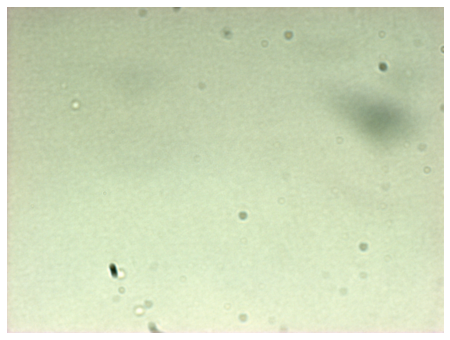

In [11]:
# acq_path = os.path.join(save_path, acq_name+"_{}".format(1))
# bg_img = io.imread((acq_path+'/bg_img.tiff'))
plt.figure(figsize=(8, 6))
imgplot = plt.imshow(exposure.rescale_intensity(bg_img[0], out_range=(0, 1)))
plt.axis("off")
plt.show()

In [13]:
stitching(config, ij, save_path=save_path, acq_name=acq_name, mda=False, position_list=position_list.reshape(position_list.shape[0]*position_list.shape[1], -1), flip_y=True, correction=True, background_image=bg_img)

 Processing tiles: 308/308
 stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\slide-sample-acq\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (853 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\slide-sample-acq\1.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (120 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\

In [16]:
export_slide(mag='4x')

In [11]:
save_path = 'data/acquisition'
acq_name = 'slide-sample-acq'
position_list_20x = annotations_positionlist(config, image_name=acq_name, out_mag='20x')

In [12]:
position_list_20x = position_list_20x[0]

In [13]:
position_list_20x

array([[ 7812.33      ,  4084.63291095],
       [ 7812.33      ,  4338.05582189],
       [ 7812.33      ,  4591.47873284],
       [ 7812.33      ,  4844.90164378],
       [ 7812.33      ,  5098.32455473],
       [ 7812.33      ,  5351.74746567],
       [ 7812.33      ,  5605.17037662],
       [ 7812.33      ,  5858.59328756],
       [ 7812.33      ,  6112.01619851],
       [ 7812.33      ,  6365.43910945],
       [ 7812.33      ,  6618.8620204 ],
       [ 8155.85883484,  3831.21      ],
       [ 8155.85883484,  4084.63291095],
       [ 8155.85883484,  4338.05582189],
       [ 8155.85883484,  4591.47873284],
       [ 8155.85883484,  4844.90164378],
       [ 8155.85883484,  5098.32455473],
       [ 8155.85883484,  5351.74746567],
       [ 8155.85883484,  5605.17037662],
       [ 8155.85883484,  5858.59328756],
       [ 8155.85883484,  6112.01619851],
       [ 8155.85883484,  6365.43910945],
       [ 8155.85883484,  6618.8620204 ],
       [ 8155.85883484,  6872.28493134],
       [ 8155.85

In [15]:
save_path = 'data/acquisition'
acq_name = 'slide-sample-test-annotation-20x'

In [21]:
switch_objective(config, core, '20x')

In [48]:
bg_20x = whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, position_list=position_list_20x, mda=False, estimate_background=True, focus_dive=False)

NameError: name 'position_list_20x' is not defined

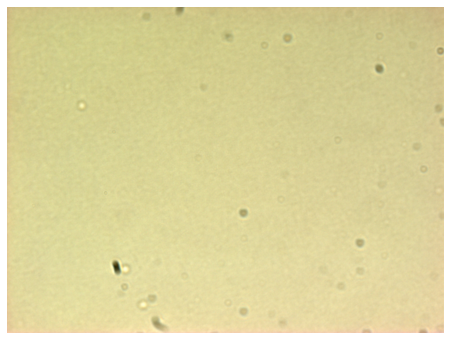

In [115]:
plt.figure(figsize=(8, 6))
imgplot = plt.imshow(exposure.rescale_intensity(bg_20x[0], out_range=(0, 1)))
plt.axis("off")
plt.show()

 253/253 tiles done

()

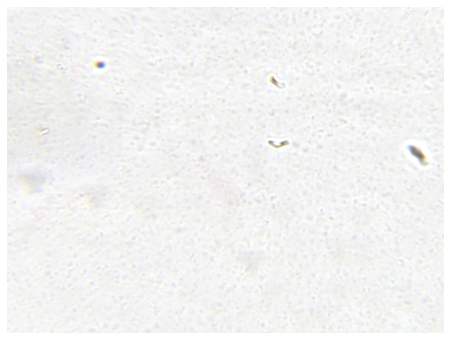

In [128]:
whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, position_list=position_list_20x, mda=False, estimate_background=False, focus_dive=False, background_image=bg_20x[0])

In [ ]:
stitching(config, ij, save_path=save_path, acq_name=acq_name, mag='20x', mda=False, position_list=position_list_20x, flip_y=True, correction=True, background_image=bg_20x[0])

In [16]:
stitching(config, ij, save_path=save_path, acq_name=acq_name, mag='20x', mda=False, position_list=position_list_20x, flip_y=True, correction=False)

 Processing tiles: 253/253
 stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\slide-sample-test-annotation-20x\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (879 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\slide-sample-test-annotation-20x\1.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (203 ms)[java.lang.Enum.toString] 
[java.

In [17]:
export_slide(mag='20x', remove_file=False)

exporting slides, please wait...


In [11]:
save_path = 'data/acquisition'
acq_name = 'slide-sample-acq'
position_list_mp = annotations_positionlist(config, image_name=acq_name, out_mag='mp')[0]

In [12]:
position_list_mp

array([[8585.415     , 4849.18925955],
       [8585.415     , 4967.91907444],
       [8585.415     , 5086.64888933],
       [8585.415     , 5205.37870421],
       [8585.415     , 5324.1085191 ],
       [8585.415     , 5442.83833399],
       [8585.415     , 5561.56814888],
       [8585.415     , 5680.29796377],
       [8585.415     , 5799.02777865],
       [8585.415     , 5917.75759354],
       [8585.415     , 6036.48740843],
       [8585.415     , 6155.21722332],
       [8704.14481489, 4611.72962978],
       [8704.14481489, 4730.45944466],
       [8704.14481489, 4849.18925955],
       [8704.14481489, 4967.91907444],
       [8704.14481489, 5086.64888933],
       [8704.14481489, 5205.37870421],
       [8704.14481489, 5324.1085191 ],
       [8704.14481489, 5442.83833399],
       [8704.14481489, 5561.56814888],
       [8704.14481489, 5680.29796377],
       [8704.14481489, 5799.02777865],
       [8704.14481489, 5917.75759354],
       [8704.14481489, 6036.48740843],
       [8704.14481489, 61

In [14]:
switch_objective(config, core, '20x')

In [18]:
switch_mod(config, core, mod='shg')

Imaging mode set as SHG


In [31]:
save_path = 'data/acquisition'
acq_name = 'slide-sample-shg-256'
whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, position_list=position_list_mp, mda=True, z_stack=True, z_center=config["Z-stage-laser"], sample_depth=54, z_step=6, estimate_background=False, focus_dive=False)

In [13]:
save_path = 'data/acquisition'
acq_name = 'slide-sample-shg-256'
stitching(config, ij, save_path=save_path, acq_name=acq_name, mod='shg', mag='20x', mda=True, z_stack=True, position_list=position_list_mp, flip_y=False, rotate=270, correction=True)

Dataset opened                 
 Processing tiles: 1429/1429
 stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\slide-sample-shg-256\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] TiffDelegateReader initializing F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\slide-sample-shg-256\0.tiff
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] dimension order is not certain, assuming XYZ instead of XYT[java.lang.Enum.toString] 
[java.lang.Enum.toString] 256x256x10px, channels=1, timepoints=1 (610 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString

In [33]:
export_slide(mag='mp', remove_file=True)

exporting slides, please wait...


In [29]:
qupath = os.path.join('QuPath-0.2.3', 'QuPath-0.2.3 (console).exe')
image_dirs = glob.glob(os.path.join('data', 'slides', 'mp', '*.tif'))
script = os.path.join('qupath-scripts', 'export-ometif-metadata-mp.groovy')  
subprocess.run([qupath, "script", script, "-i", image_dirs[0]], shell=True)

CompletedProcess(args=['QuPath-0.2.3\\QuPath-0.2.3 (console).exe', 'script', 'qupath-scripts\\export-ometif-metadata-mp.groovy', '-i', 'data\\slides\\mp\\slide-sample-shg-256.tif'], returncode=0)

In [20]:
image_dirs[0]

'data\\slides\\mp\\slide-sample-shg-256.tif'

In [31]:
def autofocus_d(config, core, method='edge', mag='4x', rgb=True, search_range=45, steps=5, snap=True, crop_ratio=1.0, flip_channel=True, check_background=True, offset=0):
    if mag=='4x':
        drift_limit = config["Z-stage-4x"]
    if mag=='20x':
        drift_limit = config["Z-stage-20x"]
    core.set_focus_device(config["focus-device"])   
    current_z = core.get_position()
    interval_z = search_range/steps
    scores = []
    positions = []
    count = 0
    for step in range(-int(np.floor(steps/2)), int(np.ceil(steps/2))):
        position_z = step * interval_z + current_z
        if position_z < config["hard-limit-z"][0] or position_z > config["hard-limit-z"][1]:
            print("z-stage out of range, new focus discarded")
            break
        core.set_position(position_z)
        core.wait_for_system()
        count = count + 1
        pixels = snap_image(core, rgb=rgb, flip_channel=True)
        if check_background and step==-int(np.floor(steps/2)):
            bg_flag = is_background(pixels)
            if bg_flag:
                core.set_position(drift_limit)
                core.wait_for_system()
#                 print("Is background")
                return current_z, pixels, bg_flag
        img_gray = color.rgb2gray(pixels)
        if method == 'entropy':
            score = shannon_entropy(img_gray)
        if method == 'edge':
            score = np.mean(sobel(img_gray))
#         print(str(score) + " " + str(position_z))
        scores.append(score)
        positions.append(position_z)
    scores_array = np.asarray(scores)
    positions_array = np.asarray(positions) 
    new_length = len(positions) * 100
    new_x = np.linspace(positions_array.min(), positions_array.max(), new_length)
    new_y = sp.interpolate.interp1d(positions_array, scores_array, kind='cubic')(new_x)
    idx = np.argmax(new_y)
    focus_z = new_x[idx]
    if focus_z < config["hard-limit-z"][0] or focus_z > config["hard-limit-z"][1]:
        print("z-stage out of range, new focus discarded")
        focus_z = position_z
    if np.abs(focus_z-drift_limit) > 1000:
        print("z-stage out of range, reset focus")
        focus_z = config["Z-stage-4x"]
        core.set_position(focus_z)
        core.wait_for_system()
    else:
        core.set_position(focus_z)
        core.wait_for_system()
    if snap:
        pixels = snap_image(core, rgb=rgb, flip_channel=True)
        return focus_z+offset, pixels, False
    else:
        return focus_z+offset, None, False

def is_background_d(img, t=0.2):
#     img = transform.resize(img, (1024, 1024))
    patch_h = int(img.shape[0]/8)
    patch_w = int(img.shape[1]/8)
    img = color.rgb2hsv(img)
    img_windows = np.squeeze(view_as_windows(img, (patch_h, patch_w, 3), step=(patch_h, patch_w, 3)))
    img_windows = np.reshape(img_windows, (img_windows.shape[0]*img_windows.shape[1], patch_h, patch_w, 3)) # nxm, 256, 256, 3
    img_max = np.max(img_windows, axis=0) # 256x256x3
    img_min = np.min(img_windows, axis=0) # 256x256x3
    sat_img = img_max[:, :, 1]
    bright_img = 1-img_min[:, :, 2]
    ave_sat = np.sum(sat_img)/(patch_h*patch_w)
    ave_bright = np.sum(bright_img)/(patch_h*patch_w)
    print(ave_sat)
    print(ave_bright)
    return ave_sat < t and ave_bright < t*2

In [33]:
switch_objective(config, core, '4x')
focus, _, _ = autofocus_d(config, core, method='edge', snap=False, search_range=1000)
focus, pixels, _ = autofocus_d(config, core, method='edge', snap=True, search_range=250)
focus

-2200.0099999999998

In [73]:
focus, pixels = autofocus_d(config, core, method='edge', snap=True, search_range=250)

0.007096521989230308 -3381.05
0.0074207707305932276 -3331.05
0.007767586094119075 -3281.05
0.008116527349054619 -3231.05
0.008513806414398624 -3181.05


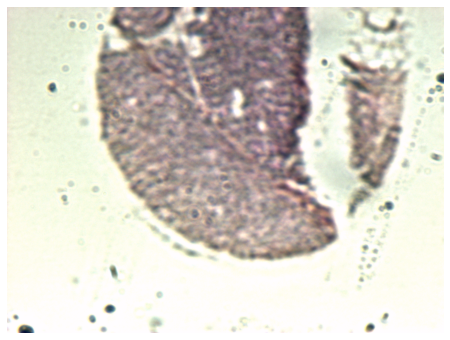

In [82]:
pixels = snap_image(core, rgb=True, flip_channel=True)
plt.figure(figsize=(8, 6))
imgplot = plt.imshow(exposure.rescale_intensity(pixels))
plt.axis("off")
plt.show()

In [84]:
is_background_d(pixels)

0.22392677092340818
0.520418161959744


False

In [57]:
img = color.rgb2hsv(pixels)
img_windows = np.squeeze(view_as_windows(img, (174, 260, 3), step=256))
img_windows = np.reshape(img_windows, (img_windows.shape[0]*img_windows.shape[1], 174, 260, 3)) # nxm, 256, 256, 3
img_max = np.max(img_windows, axis=0) # 256x256x3
sat_img = 1-img_max[:, :, 2]
plt.figure(figsize=(8, 6))
imgplot = plt.imshow(exposure.rescale_intensity(sat_img))
plt.axis("off")
plt.show()

ValueError: cannot reshape array of size 2714400 into shape (20,256,256,3)

In [54]:
np.sum(sat_img)/(256*256)

0.008855602787990196

In [12]:
annotation_path = filedialog.askopenfilename(filetypes=(("Json annotation files","*.json"),("All files","*.*")))
coords = extract_rois(config, 'example/qupath-pj/annotation results/BIC14011b.jpg.json', image_size=(22689, 15080))

FileNotFoundError: [Errno 2] No such file or directory: 'example/qupath-pj/annotation results/BIC14011b.jpg.json'

In [141]:
bposition_list_z = focus_dive(core, position_list, search_range=18, resample_grid_size=(position_list_20x.shape[0], position_list_20x.shape[1]))

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:13<00:00,  1.13s/it]


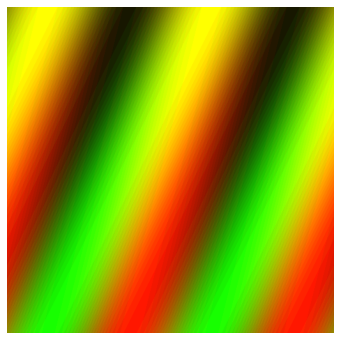

In [25]:
core.set_position(20)
core.wait_for_system()
core.snap_image()
tagged_image = core.get_tagged_image()
rgb = True
if rgb == True:
    pixels = np.reshape(
        tagged_image.pix,
        newshape=[tagged_image.tags["Height"], tagged_image.tags["Width"], 4],
        )
else:
    pixels = np.reshape(
        tagged_image.pix,
        newshape=[tagged_image.tags["Height"], tagged_image.tags["Width"]],
        )
pixels = pixels[:, :, 0:3]
pixels=np.flip(pixels, 2)
plt.figure(figsize=(8, 6))
imgplot = plt.imshow(exposure.rescale_intensity(pixels, out_range=(0, 1)))
plt.axis("off")
plt.show()

In [ ]:
### load libraries
bridge = Bridge()
core = bridge.get_core()
ij = imagej.init('fiji\\fiji\\Fiji.app')
Image.MAX_IMAGE_PIXELS = None  
core.set_timeout_ms(20000)

In [ ]:
### collect brightfield image
save_path = 'data/acquisition'
acq_name = 'slide-bf-test'
position_list, grid = generate_grid(config, mag='4x')
estimated_background_img = whole_slide_scan(config, save_path, acq_name, position_list=position_list, mda=False, core=core, estimate_background=True) # acquire 4x bf
stitching(config, ij, save_path=save_path, acq_name=acq_name, mda=False, position_list=position_list, flip_y=True, correction=True, background_image=bg_img) # stitch 4x bf

In [14]:
def export_slide(mag='4x'):
    if mag=='4x':
        script = os.path.join('qupath-scripts', 'export-ometif-metadata-4x.groovy')
    if mag=='20x':
        script = os.path.join('qupath-scripts', 'export-ometif-metadata-20x.groovy')
    if mag=='mp':
        script = os.path.join('qupath-scripts', 'export-ometif-metadata-shg.groovy')       
    qupath = os.path.join('QuPath-0.2.3', 'QuPath-0.2.3.exe')
    image_dirs = glob.glob(os.path.join('data', 'slides', '*.tif'))
    for img_dir in image_dirs:
        if img_dir.find("ome") != -1:
            continue
        subprocess.run([qupath, "script", script, "-i", img_dir], shell=True)
        os.remove(img_dir)

In [ ]:
def annotations_to_positions(config, image_type='4x'):
    if image_type == '4x':
        coords_csvs = glob.glob("qupath-projects/4x-tiles/*.csv")
    if image_type == '20x':
        off_set = config["20x-bf-offset"]
        coords_csvs = glob.glob("qupath-projects/20x-tiles/*.csv")
    if image_type == 'shg':
        off_set = config["shg-offset"]
        coords_csvs = glob.glob("qupath-projects/mp-tiles/*.csv")
    coords_list = []
    for coords_csv in coords_csvs:
        coords_df = pd.read_csv(coords_csv)
        coords_array = np.array(coords_df)
        coords_array[:, 0] = coords_array[:, 0] + offset[0]
        coords_array[:, 1] = coords_array[:, 1] + offset[1]
        coords_list.append(coords_array)
    return coords_list

In [9]:
coords_list

[array([[   0.,    0.],
        [   0.,  990.],
        [   0., 1980.],
        [   0., 2970.],
        [1270.,    0.],
        [1270.,  990.],
        [1270., 1980.],
        [1270., 2970.],
        [2540.,    0.],
        [2540.,  990.],
        [2540., 1980.],
        [2540., 2970.],
        [3810.,    0.],
        [3810.,  990.],
        [3810., 1980.],
        [3810., 2970.]])]

In [21]:
script = os.path.join('qupath-scripts', 'export-entire-image-as-patches-4x.groovy')
qupath = os.path.join('QuPath-0.2.3', 'QuPath-0.2.3.exe')
image_dirs = glob.glob(os.path.join('data', 'slides', '*.tiff'))
for img_dir in image_dirs:
    subprocess.run([qupath, "script", script, "-i", img_dir], shell=True)

In [22]:
macro = """
    #@ String inDir
    #@ String outDir
    slices = getFileList(inDir);
    for (i=0;i<lengthOf(slices);i=i+1) {
        filePath = inDir + '/' + slices[i];
        open(filePath);
    }
    run("Merge Channels...", "c1=img_t1_z1_c1 c2=img_t1_z1_c2 c3=img_t1_z1_c3 create");
    saveAs("Tiff", outDir);
    """
args = {
        'inDir': os.path.join(os.getcwd(), 'data/stitching/channel_temp'),
        'outDir' : os.path.join(os.getcwd(), os.path.join('data/slides', acq_name+'.tif'))
    }

In [23]:
result = ij.py.run_macro(macro, args)

In [ ]:
os.getcwd()